# Using statistics and machine learning to complement simulation-based modeling

This document serves as a proof of concept demonstrating how statistics and machine learning approaches can be used to extract maximum value from datasets generated via simulation-based modeling campaigns. As an example case, we've used a water collection system simulation dataset with the following key variables:

* Inputs/Predictor Variables: Observed rainfall & water level
* Outputs/Response Variable: Simulated combined sewer overflow (CSO) data

While the approaches are applied in a water collection system context, the ideas are relevant in the context of any simulation exercise including in the areas of transportation, climate, etc.

There are two primary value-added products:

* Ability to generate estimates of the response variable(s) for a given scenario extremely quickly (fraction of a second)

* Greater understanding of trends across simulations, including intelligence regarding the sensitivity of the repsonse variable to changes in the input variables

## 1. Config/setup

Set user settings and import modules

In [1]:
#Parameters/settings

#Filepaths
data_dir = r"\\hchfpp01\Groups\WBG\MillCreek\Analysis\Prediction\data"
h5_filename = "LittleMiamiData.h5"
working_dir = r"\\hchfpp01\Groups\WBG\MillCreek\Analysis\Prediction\working" #where to write files
param_summary_file = r"\\hchfpp01\Groups\WBG\MillCreek\Analysis\Prediction\working\param_summary_ALL.csv"


cso = "CSO-136"     #CSO to analyze.  Corresponds to a group in the h5 file
field = "rainfall"  #variable used to define events
IE_hr = 12          #inter-event period, in hours
ts = 5              #timestep interval of input data, in minutes
thresh = 0.001      #minimum value of 'field' to consider non-zero
resp_var = 'overflow_sum'    #response variable for stat modeling

do_fill_data = True   #fill in missing data using back-fill method?
testing = False        #run in testing mode?

event_summary_exists = True   # if True, user can run step 1 then jump to step 4

In [3]:
#Import modules and set Jupyter notebook settings
import pandas as pd
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_regress_exog
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

import eventdefsum as eds
import stat_helpers as sh

%matplotlib inline

## 2. Ingest and clean data

Read in our dataset. 

Note that there is often a non-trivial effort that goes into compiling potentially disparate model results into a single structured data format. We are starting this analysis with a collated and cleaned dataset (except the potential for a small fraction of missing data points which are filled using simple pandas backfill method here, for simplicity- however the question of how, and even if, to fill missing data should be carefully considered on a case-by-case basis).

In [3]:
#read in data
h5_fp = os.path.join(data_dir, h5_filename)
df = pd.read_hdf(h5_fp, cso)

#Handle Missing Dta: backfill: use NEXT valid observation to fill gap
if do_fill_data:
    df.fillna(method = "bfill", inplace = True)
    
#view data summary
print(df.describe())

           rainfall     cso_level     str_level     int_level      overflow
count  60481.000000  60481.000000  60481.000000  60481.000000  60481.000000
mean       0.000560    518.411407    511.687608    503.651721      0.001248
std        0.004422      0.214268     11.587538     11.405560      0.012503
min        0.000000    518.173971      0.000000      0.000000      0.000000
25%        0.000000    518.341003    511.950012    503.910004      0.000000
50%        0.000000    518.380371    511.950012    503.910004      0.000000
75%        0.000000    518.416504    511.950012    503.910004      0.000000
max        0.247113    523.256392    511.950012    503.910004      0.595864


In [4]:
#Print a summary of all data in the h5 file (testing only)
if testing:
    h5_fp = os.path.join(data_dir, h5_filename)
    h5 = h5py.File(h5_fp)
    keys = list(h5.keys())
    h5.close()
    
    for key in keys:
        print(key)
        _df = pd.read_hdf(h5_fp, key)
        _df.fillna(method = "bfill", inplace = True)
        print(_df.describe())
        print('-----------')

## 3. Transform data

Define and summarize rainfall events using some custom Python functions

We end up with a dataframe containing one record/row for each storm event, and several fields/columns summarizing key characteristics of the event.

Our response variable is **overflow_sum** (Total CSO overflows, MG).

In [5]:
#define events
df_event = eds.define_events(df, field, IE_hr, ts, thresh)

#add datetime column from index for event summary function
df_event = eds.addDateTimeColumnFromIndex(df_event)
aggmap = eds.get_MSD_aggmap()

#summarize events
df_event_summary = eds.summarize_events(df_event, aggmap)

#write summary df to CSV
fp_csv_out = os.path.join(working_dir, cso + "_event_summary.csv")
df_event_summary.to_csv(fp_csv_out)

#view data summary
print(df_event_summary.describe())


       rainfall_max  rainfall_sum  rainfall_mean  cso_level_max  \
count     67.000000     67.000000      67.000000      67.000000   
mean       0.041464      0.505290       0.001339     519.313373   
std        0.055316      0.822547       0.001608       1.159764   
min        0.000146      0.000146       0.000001     518.272159   
25%        0.007123      0.053368       0.000236     518.455804   
50%        0.017171      0.187652       0.000747     518.908971   
75%        0.050231      0.636233       0.001832     519.595678   
max        0.247113      4.512364       0.007529     523.256392   

       cso_level_mean  str_level_max  str_level_mean  int_level_max  \
count       67.000000   6.700000e+01       67.000000   6.700000e+01   
mean       518.446147   5.119500e+02      511.645775   5.039100e+02   
std          0.149279   5.727243e-13        2.490292   1.718173e-13   
min        518.242046   5.119500e+02      491.566091   5.039100e+02   
25%        518.381034   5.119500e+02     

## 4. Visualize (explore relationships)

Print a list of all variables (columns)

For reference, 'str' = stream and 'int' = interceptor

In [6]:
if event_summary_exists:
    fp_csv_out = os.path.join(working_dir, cso + "_event_summary.csv")
    df_event_summary = pd.read_csv(fp_csv_out, index_col = "event")

list(df_event_summary.columns)

['rainfall_max',
 'rainfall_sum',
 'rainfall_mean',
 'cso_level_max',
 'cso_level_mean',
 'str_level_max',
 'str_level_mean',
 'int_level_max',
 'int_level_mean',
 'overflow_max',
 'overflow_mean',
 'overflow_sum',
 'duration_hrs']

Create a pairplot to visualize correlations amongst variables. 

We are interested in any variables that have a strong correlation with our response variable overflow_sum.

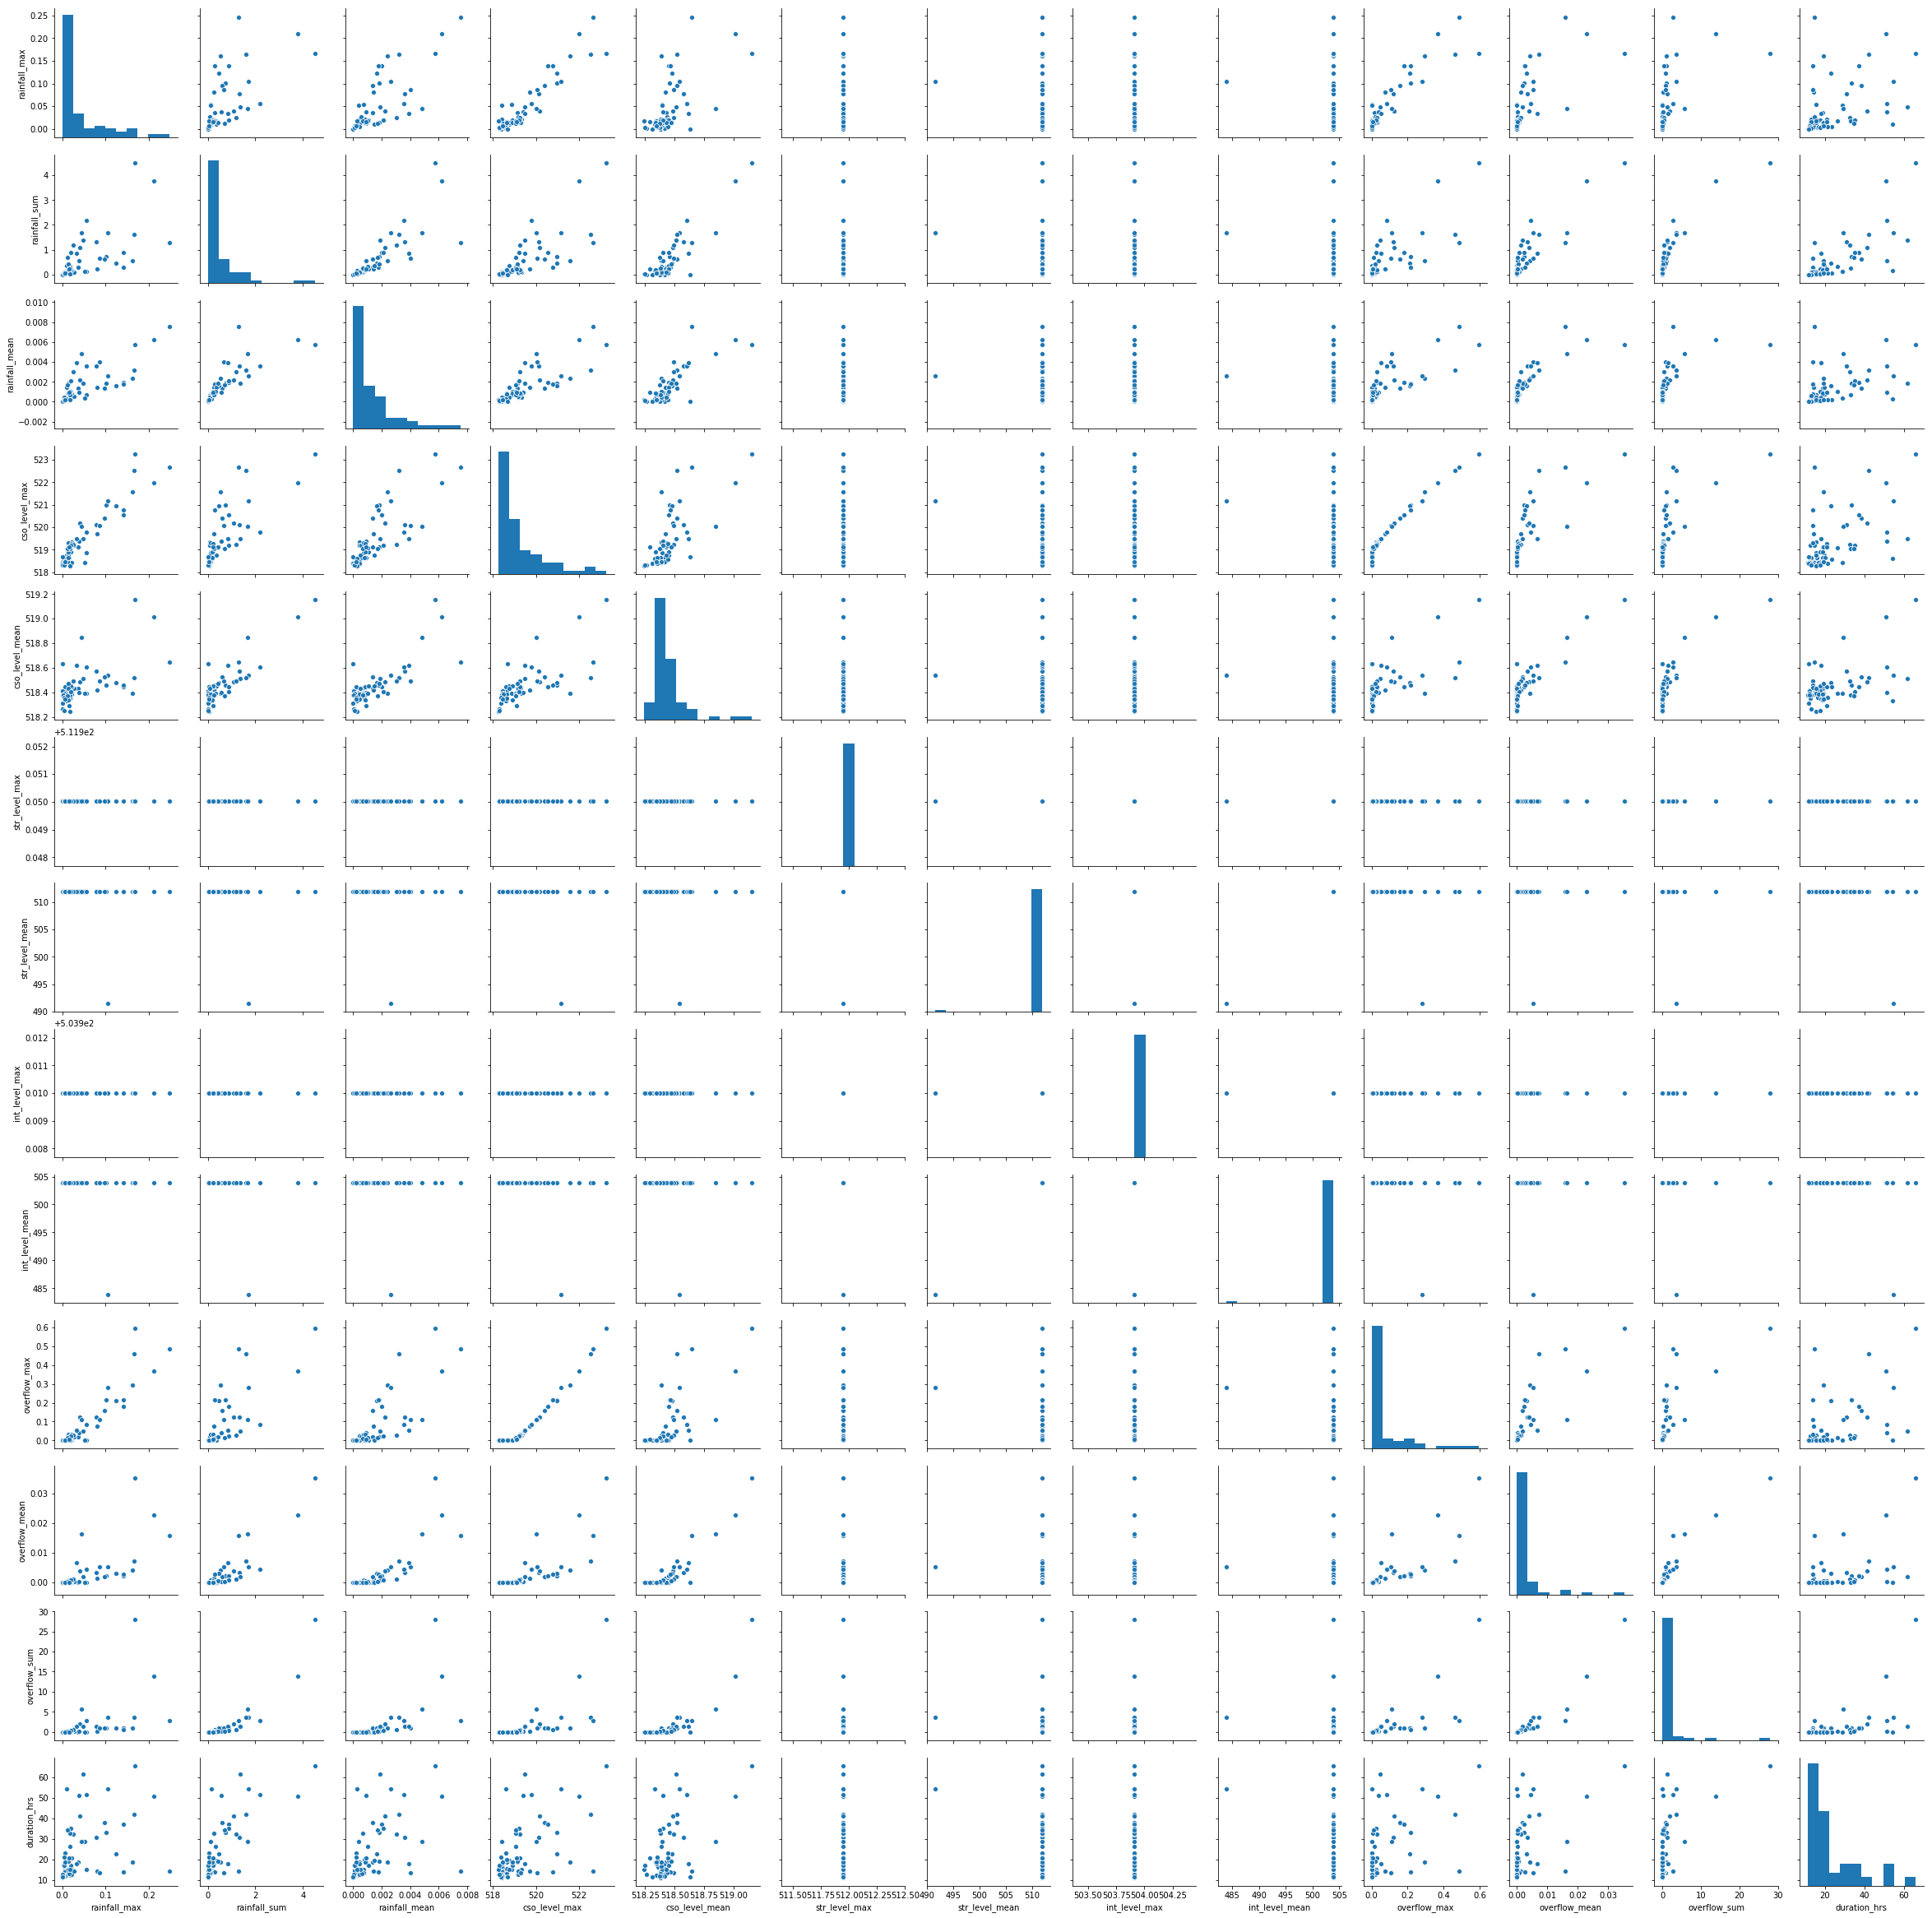

In [7]:
fp_out = os.path.join(working_dir, cso + "_pairplot.png")
sh.save_pairplot(df_event_summary, fp_out)

Review of the above pairplot shows that the str_level_x (stream level) and int_level_x (interceptor level) variables 
are essentially constant over time (i.e. very poor correlation with our response variable overflow_sum).  Drop these, and re-create a reduced pairplot figure.

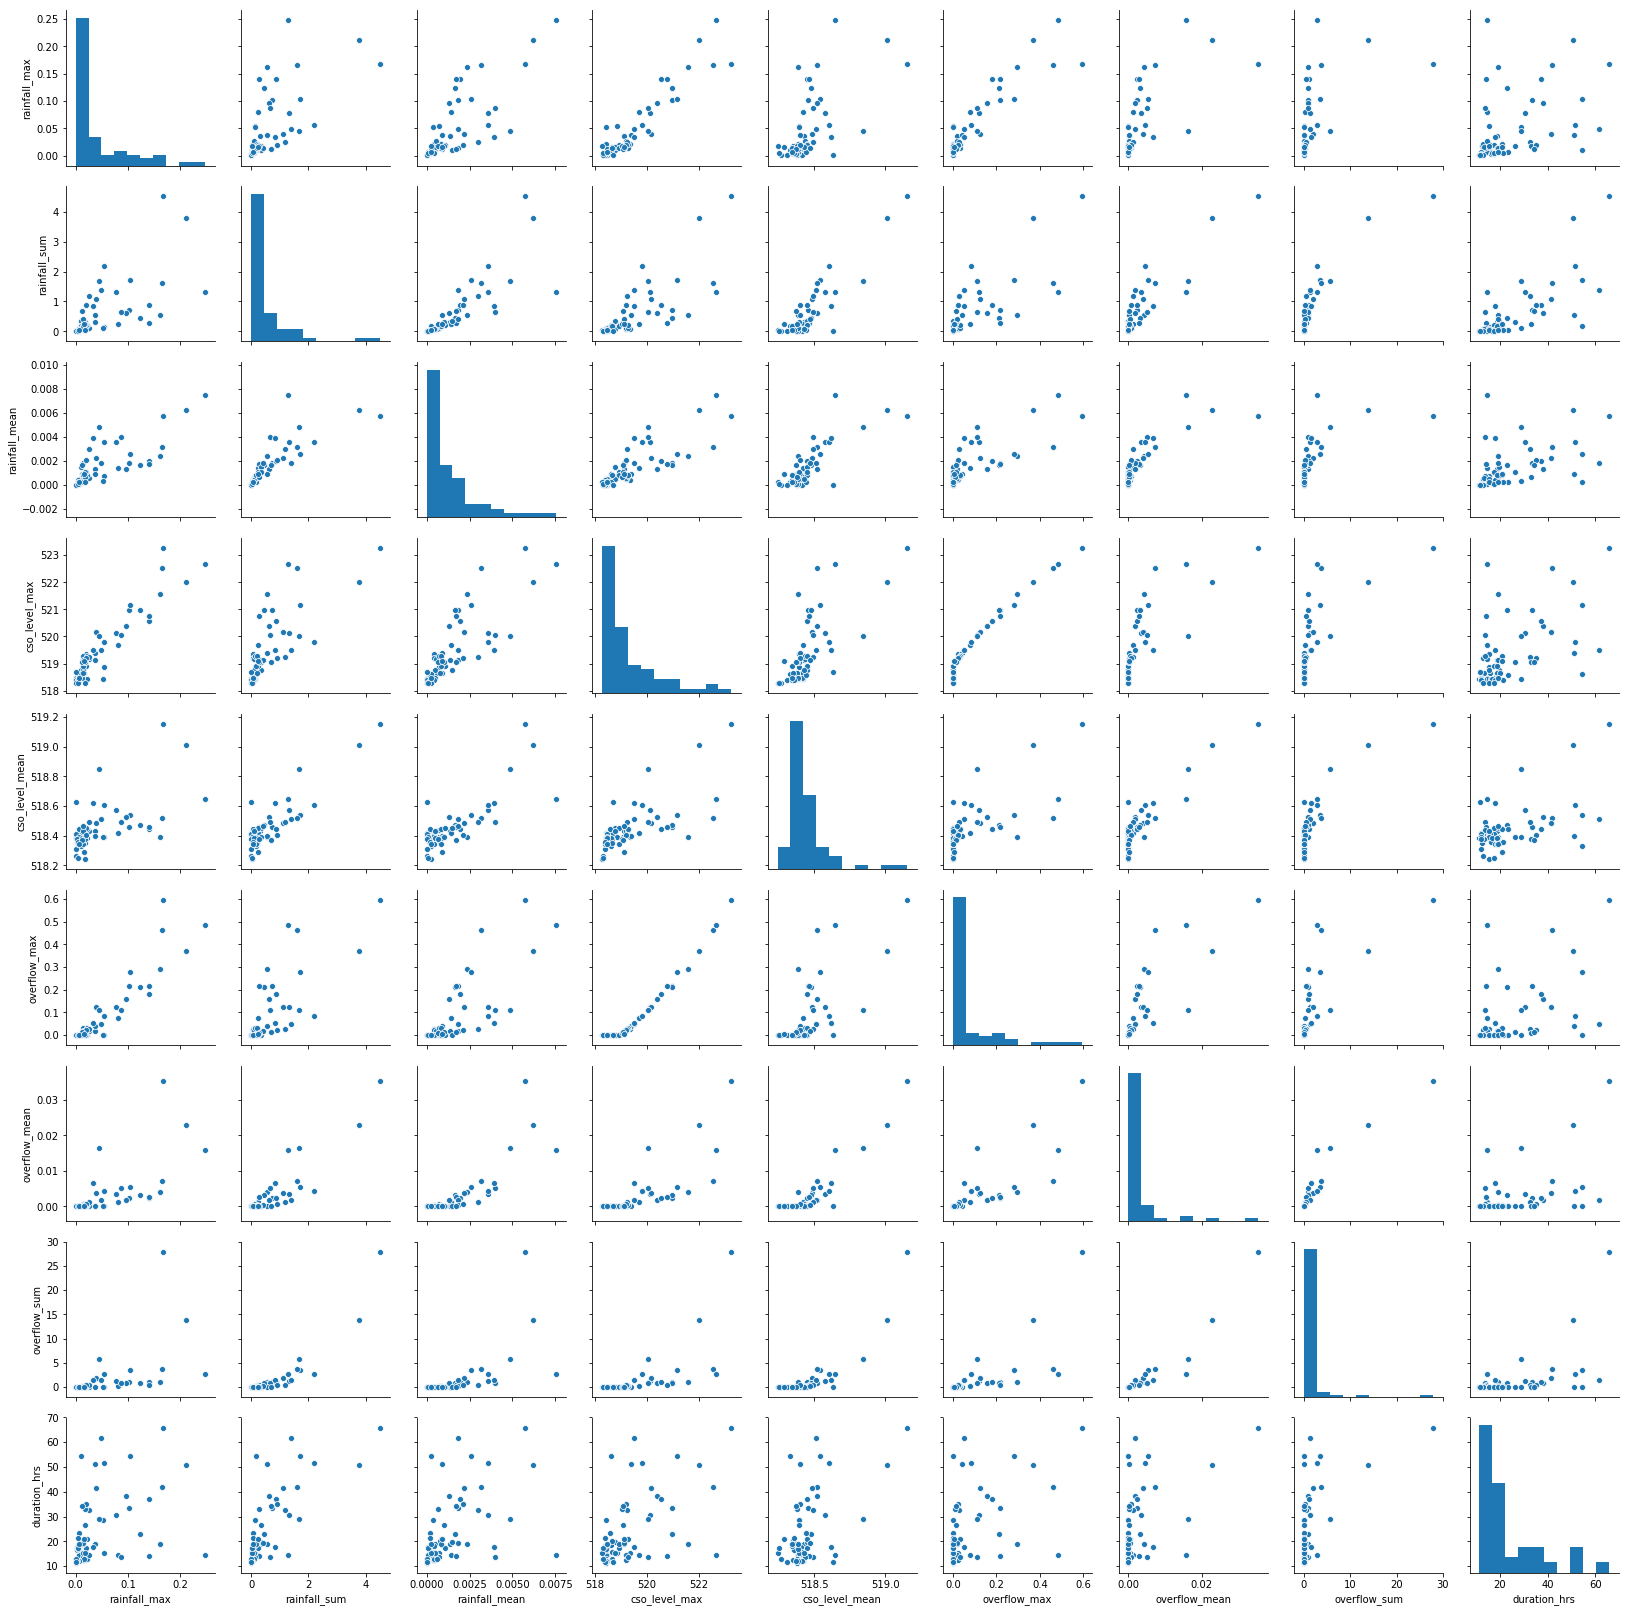

In [8]:
drop_cols= [x for x in df_event_summary.columns.tolist() if 
            (x.startswith("str") or x.startswith("int"))]
df_event_summary.drop(labels = drop_cols, axis = 1, inplace = True)

fp_out = os.path.join(working_dir, cso + '_pairplot_reduced.png')
sh.save_pairplot(df_event_summary, fp_out)

Combining domain knowledge with variable correlation insights provided by the above pairplot, we select the following variables as candidate predictor variables (again, to predict overflow_sum):

* rainfall_sum (Total Rainfall Depth, in)
* rainfall_max (Max Rainfall Intensity, in/hr)
* cso_level_max (Max Level at outfall, ft AD)
* cso_level_mean (Mean Level at outfall, ft AD)
* duration_hrs  (Duration of the storm event, hours)

Now, set up simple linear regression model using these variables as predictors. 
We will use the statsmodels module to perform the linear regression analysis.  scikit-learn also includes linear regression capabilities and provides an awesome interface, but does not offer regression insights as readily as statsmodels ([module comparison](https://blog.thedataincubator.com/2017/11/scikit-learn-vs-statsmodels/)).

In [9]:
keep_vars = ['rainfall_sum', 'rainfall_max', 'cso_level_max', 'cso_level_mean',
             'duration_hrs', 'overflow_sum']

df_model = df_event_summary[keep_vars]
pred_vars = keep_vars[:-1] #response var is last

formula = sh.build_sm_formula(pred_vars, resp_var)
print(formula)
print('----------')

# Fit ordinary least squares model and view summary       
lm_res = smf.ols(formula, data=df_model).fit()
print(lm_res.summary())
print('------VIFs------')
print(sh.get_vifs(df_model))

overflow_sum ~ rainfall_sum + rainfall_max + cso_level_max + cso_level_mean + duration_hrs
----------
                            OLS Regression Results                            
Dep. Variable:           overflow_sum   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     54.06
Date:                Fri, 19 Apr 2019   Prob (F-statistic):           3.86e-21
Time:                        13:58:04   Log-Likelihood:                -128.25
No. Observations:                  67   AIC:                             268.5
Df Residuals:                      61   BIC:                             281.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

After review of the regression summary and the [Variance Inflation Factors (VIF)](https://en.wikipedia.org/wiki/Variance_inflation_factor), it appears that __cso_level_max__ is not a good predictor (high [p-value](https://en.wikipedia.org/wiki/P-value)) and has high multicollinearity (with __cso_level_mean__).

Therefore, we choose to drop __cso_level_max__ as a predictor variable and rebuild the model

In [10]:
keep_vars = ['rainfall_sum', 'rainfall_max', 'cso_level_mean',
             'duration_hrs', 'overflow_sum']

df_model2 = df_event_summary[keep_vars]
pred_vars = keep_vars[:-1] #response var is last

formula2 = sh.build_sm_formula(pred_vars, resp_var)
lm_res2 = smf.ols(formula2, data=df_model2).fit()
print(lm_res2.summary())
print('------VIFs------')
print(sh.get_vifs(df_model2))

                            OLS Regression Results                            
Dep. Variable:           overflow_sum   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     68.30
Date:                Fri, 19 Apr 2019   Prob (F-statistic):           5.01e-22
Time:                        13:58:04   Log-Likelihood:                -128.40
No. Observations:                  67   AIC:                             266.8
Df Residuals:                      62   BIC:                             277.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2846.1913   1727.105     -1.

Now all predictor variables have a significance/p-value of about 0.10 or lower and all
VIF values are less than 10.

It seems we have a decent model- but we should review the residual plots to confirm that none of the [linear regression assumptions](https://en.wikipedia.org/wiki/Linear_regression#Assumptions) are violated.



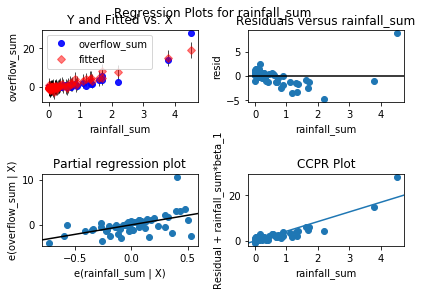

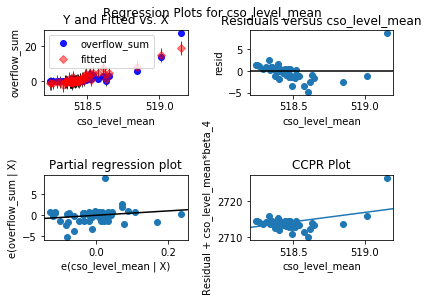

In [11]:
fig_resid = plot_regress_exog(lm_res, 'rainfall_sum')
fp_out = os.path.join(working_dir, cso + "_residPlot_rainfall_sum.png")
fig_resid.savefig(fp_out, dpi = 500, transparent = True)

fig_resid = plot_regress_exog(lm_res, 'cso_level_mean')
fp_out = os.path.join(working_dir, cso + "_residPlot_cso_level_mean.png")
fig_resid.savefig(fp_out, dpi = 500, transparent = True)

The residual plots show that there is strong non-linearity.  Based on the previously generated pairplots and domain knowledge, we can conclude that is most likely due to [non-linear relationship](http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/#nonlinear-header) between system rainfall, water levels, and overflows. 

We could do some [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) (create a $x^2$ variable, for instance).... OR, we can try a more sophisticated machine learning model that can automatically account for higher-order interactions, like a [Random Forest model](https://en.wikipedia.org/wiki/Random_forest).


First, we'll split the data into subsets: training and testing datasets.  

Then, we initilize the model, fit the model on the training data, and finally predict the response variable for our test set.  This approach allows us to test (validate) the model with data that was not used to build it in the first place.

This workflow is standard across scikit-learn models.

Note that we are also timing how fast the model can make predictions on the test dataset.

In [12]:
X = df_model2.iloc[:,:-1]
y = df_model2.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3,
                                                    random_state= 42)

rf_model1 = RandomForestRegressor(n_estimators= 1000, max_features= 0.33, 
                                  n_jobs= -1, random_state= 42)
rf_model1.fit(X_train, y_train)

import time
tstart = time.time()
rf1_test_pred = rf_model1.predict(X_test)
tend = time.time()
rf1_train_pred = rf_model1.predict(X_train)
print("{} predictions for the test dataset took {} seconds".format(X_test.shape[0], round(tend-tstart, 3)))

21 predictions for the test dataset took 0.125 seconds


We will print the [feature importances](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py), to understand the relative importance of the predictor variables in predicting our response variable __overflow_sum__.

The output and plot below shows that the predictor variables __rainfall_sum__ and __cso_level_mean__ are the most important for predicting overflow in our Random Forest regression model. 

If we instead use the p-value from the linear regression to determine the most important variables (refer to regression summary table above), we see that __rainfall_sum__ and __duration_hrs__ are the most important.  The variable __rainfall_sum__ appears as a top predictor in both models.

['rainfall_sum', 'rainfall_max', 'cso_level_mean', 'duration_hrs']
[0.28144259 0.22988947 0.29216762 0.19650031]


Text(0, 0.5, 'Predictor Variable')

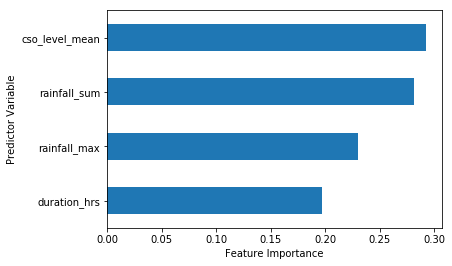

In [13]:
print(pred_vars)
print(rf_model1.feature_importances_)
df_importances = pd.DataFrame(rf_model1.feature_importances_, pred_vars) #sort_values(by= "0")
ax = df_importances.sort_values(0).plot.barh(legend = False)
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Predictor Variable")

Now that we have some understanding of which predictor variables are the most important for predicting overflows, let's assess how well these variables can actually predict the overflow volume for a given storm event...

_How good is our Random Forest regression model?_

Let's visualize the actual vs. predicted overflows for the TRAINING dataset, and calculate the $R^{2}$ value.

Keep in mind, this is data that the model "knew" of when it was built, so it should be a pretty good fit.

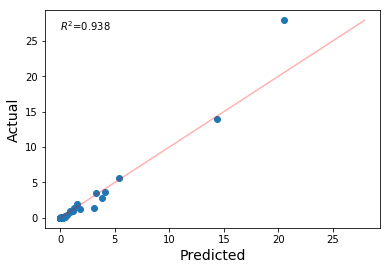

In [14]:
sh.plot_actual_vs_pred(rf1_train_pred,y_train)

Indeed it is.  
Let's do the same for the TEST dataset.  
This allows us to see how the model does "in the wild"- in other words, how it performs on data that is has not yet seen.

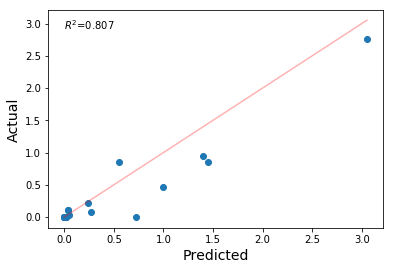

In [15]:
sh.plot_actual_vs_pred(rf1_test_pred, y_test)

Not too bad!  The Random Forest model seems to be able to predict the overflows respectably well ($R^2$ value above 0.8).

Let's now go back to simple linear regression, this time using scikit-learn (rather than statsmodels).

We'll generate similar plots to assess the performance of the model, and use these as a benchmark for the Random Forest model.  Ordinary least squares linear regression offers a decent benchmark because it is a very simple and transparent statistical modeling approach.

In [21]:
lr_model1 = LinearRegression()
lr_model1.fit(X_train, y_train)

lr1_test_pred = lr_model1.predict(X_test)
lr1_train_pred = lr_model1.predict(X_train)

**Linear Regression Model Performance for the Training Dataset:**

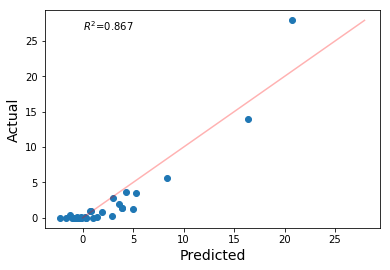

In [24]:
sh.plot_actual_vs_pred(lr1_train_pred,y_train)

**Linear Regression Model Performance for the Test Dataset:**

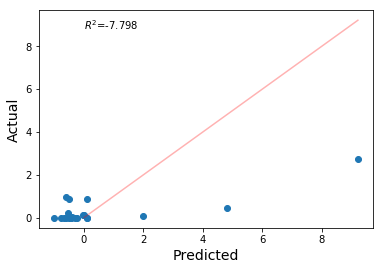

In [25]:
sh.plot_actual_vs_pred(lr1_test_pred,y_test)

Note the apparent curvature in the **training** dataset results plot (top), and the horrific fit on the **test** dataset (bottom).

In fact, the $R^2$ for the **test dataset is negative!**  This means that our linear regression model performs [worse than a simple horizontal line](https://stats.stackexchange.com/questions/12900/when-is-r-squared-negative).

Clearly, the Random Forest regression model is better at capturing the non-linearities and interactions that are inherent in the complex, real-world system.

Let's test the Random Forest model a bit further before wrapping up this analysis.  
Doing a train-test split to validate a machine learning model is good practice, but a more robust approach to model validation is _cross-validation_. Cross-validation is like doing a bunch of different train-test splits on the dataset, and evaluating model performance across all the splits. 

First, we'll use scikit-learn's cross-validation functionality to create a python generator object that yields the different ways to split up the data, then we'll loop through each split and calculate/record the $R^{2}$ value.

In [69]:
num_folds = 10
kf = KFold(n_splits = num_folds, shuffle = True, random_state=11)
train_test_folds = kf.split(X)

In [71]:
arrayr2 = np.zeros(num_folds)
i = 0
for tr, te in train_test_folds:

    rf_model_cv = RandomForestRegressor(n_estimators=1000, max_features=0.33, n_jobs=-1, random_state=11)
    rf_model_cv.fit(X.iloc[tr,:],y.iloc[tr])
    rf_test_pred = rf_model_cv.predict(X.iloc[te,:])
    arrayr2[i] = r2_score(y.iloc[te],rf_test_pred)

    i+=1

print(arrayr2)
print("\nMedian value = {}".format(round(np.median(arrayr2),2)))

[ 0.41111899  0.7484842   0.91395785  0.90054686  0.82582293  0.09476235
 -3.41454923  0.99878841  0.35653465  0.85189771]

Median value = 0.79


The array printed above shows the Random Forest model's $R^{2}$ value for each of the 10 different data split.  The $R^{2}$ values range from **-3.41 to 0.91**, with a median of **0.79**, indicating that our Random Forest model _typically_ performs well- however, there are certain data splits for which is performs very poorly.  This was not clear from our initial checks of the Random Forest model, and thus demonstrates the value of cross-validation.

A thorough analysis would include further investigation to understand why some data splits lead to extremely poor $R^2$ values; however that is outside the scope of this PoC-level analysis.



Finally, in the spirit of validating our results across many iterations for robustness, we'll look at a summary of the Random Forest model feature imporantances across different model locations and data splits (relative importance of each predictor variable, such that the values for all predictor variables sum to 1). 

This data was previously compiled in a separate analysis, fitting a Random Forest model to each model outfall location and each data split, and recording the feature importance value.  Here, we simply read in the data and visualize using the [seaborn](https://seaborn.pydata.org/index.html) module.

In the [Violin Plot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) below, each 'violin' represents the distribution of the feature importances for a predictor variable across the model locations and iteration (data splits), where the width of the violin indicates the relative freqency of the variable at that level.

For example, looking at the blue violin representing the distribution of **rainfall_sum** predictor variable feature importances, we can say that, across all model locations and dataset splits, the feature importance value almost always falls with the range of 0.15 to 0.35, with the most common value being just below 0.3 (widest part of the violin).  Across the full plot, we can see that **rainfall_sum** and **cso_level_mean** tend to be the most important predictor variables, while **rainfall_max** and **duration_hrs** are slightly less important, but still significant.  This is in agreement with our previous results.

In [16]:
df_param_summary = pd.read_csv(param_summary_file)
df_param_summary = df_param_summary[df_param_summary["Importance"] != 0] #drop zeros (likely data error)

In [25]:
sns.violinplot(data = df_param_summary, x = 'VarLabel', y = 'Importance')

.

.

.

.

**In summary**, we've accomplished the following:

* Summarized input/output data from many simulations by storm event
* Explored the data to understand which variables are correlated with our target response variable
* Applied both linear regression and Random Forest models to the data
* Identified a subset variables that predict our response variable with reasonable accuracy

Revisting the value-added products, our analysis provides the following:

* Ability to produce estimate of overflow in well under a hundreth of a second*
* Insights regarding the variables to which overflow is most sensitive:

    * Mean water level (cso_level_mean)
    * Total rainfall depth (rainfall_sum)
    * Max rainfall intensity (rainfall_max)
    * Event duration (durations_hrs)
    
*Users should be careful to avoid applying the statistical model to cases outside the bounds for which the model was trained (i.e. the range of simulations conducted), since there are no underlying process-based equations.
 
A few final highlights of our analysis:

* The Random Forest model predicted overflow volumes with a **median $R^2$ value of about 0.8**
* After data compiling/cleaning, the model was created with **just a handful of lines of code** in Python module scikit-learn
* Model execution is super fast:  well **over 100 predictions per second**.

 
Given the generally strong model performance and fast execution, a similar modeling approach could be valuable for **real-time modeling**, **alert systems**, or **interactive applications.**

------------------------------------------------------------------------------------------------------------
 
 
_This document was generated using Jupyter notebook (v5.7.4) from the Anaconda Python (v3.7.1) distribution._